Imports

In [1]:
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

from skimage import measure

Collecting data paths in list of dictionaries

In [2]:
data_path = 'data\\cropped_data'
x_list = glob.glob(os.path.join(data_path, "**\\x.nii.gz"), recursive=True)
y_list = glob.glob(os.path.join(data_path, "**\\y.nii.gz"), recursive=True)

data_dicts = [{'image':image_name, 'label':label_name} for image_name, label_name in zip(x_list, y_list)]

Loading nifiti images

In [3]:
images, labels = [], []
for data_dict in data_dicts:
    images.append(nib.load(data_dict['image']))
    labels.append(nib.load(data_dict['label']))

In [4]:
for image, label in zip(images, labels):
    print(image.shape, image.dataobj.dtype, label.shape, label.dataobj.dtype)

(714, 806, 713) uint8 (714, 806, 713) uint16
(714, 806, 713) uint8 (714, 806, 713) uint16
(772, 787, 748) uint8 (772, 787, 748) uint16
(772, 677, 797) uint8 (772, 677, 797) uint16
(816, 364, 972) uint8 (816, 364, 972) uint16
(783, 798, 791) uint8 (783, 798, 791) uint16


In [5]:
(images[0].affine == labels[0].affine).all()

False

- images and labels are of the same shape, however these shapes differ among samples in dataset  
- images are of type uint8, labels are uint16  
- data is in 3d (width, height, depth), but there is no color channel, meaning images are grey
- images and labels have different affine matrices, will be displayed in different positions in space

Converting label affine matrix to match image

In [4]:
for idx, image in enumerate(images):
    affine = image.affine
    labels[idx] = nib.Nifti1Image(labels[idx].dataobj, affine=affine)

In [7]:
(images[0].affine == labels[0].affine).all()

True

Example slices of an image and it's label:

In [8]:
img_slices = [images[0].dataobj[...,idx] for idx in range(100, images[0].dataobj.shape[2], 100)]
label_slices = [labels[0].dataobj[...,idx] for idx in range(100, labels[0].dataobj.shape[2], 100)]

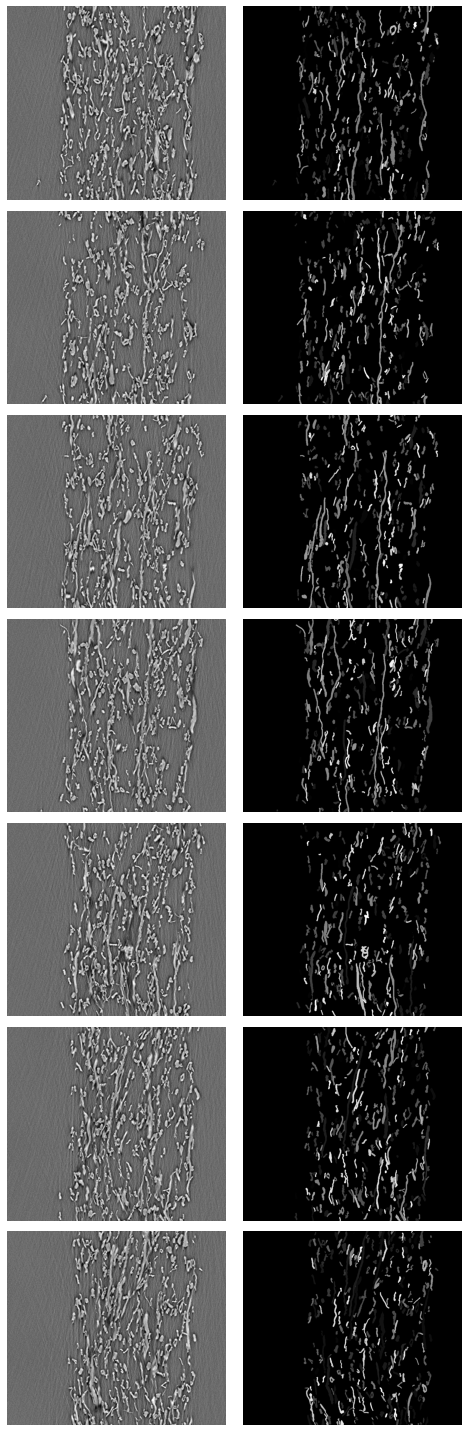

In [ ]:
fig = plt.figure(figsize=(7, 20))
cols = 2
rows = len(img_slices)
for fig_idx, data_idx in zip(range(1, cols*rows, 2), range(len(img_slices))):
    fig.add_subplot(rows, cols, fig_idx)
    plt.imshow(img_slices[data_idx], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    fig.add_subplot(rows, cols, fig_idx+1)
    plt.imshow(label_slices[data_idx], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

Closer look at labels

In [ ]:
print(f"Number of classes: {len(np.unique(labels[0].dataobj))}\
        Classes between: {np.min(labels[0].dataobj)}-{np.max(labels[0].dataobj)}")

Number of classes: 999        Classes between: 0-1001


In [ ]:
label_nums = np.max(labels[0].dataobj)
unique_labels = np.unique(labels[0].dataobj)
for tag in range(label_nums):
    if tag not in unique_labels:
        print(tag)

510
566
730


- there are 999 classes, but for semantic segmentation we only need to distinguish between background (labeled 0) and not background (labeled 1), so everything that's not 0 should be converted to 1  
- labels 510, 566 and 730 are missing

Converting labels for semantic segmentation task

In [5]:
for idx, label in enumerate(labels):
    header = label.header
    header.extensions.clear()
    affine = label.affine
    dataobj = np.array(label.dataobj, dtype=bool).astype(np.uint8)
    labels[idx] = nib.Nifti1Image(dataobj, affine, header)

In [ ]:
print(f"Number of classes: {len(np.unique(labels[0].dataobj))}\
        Classes between: {np.min(labels[0].dataobj)}-{np.max(labels[0].dataobj)}")

Number of classes: 2        Classes between: 0-1


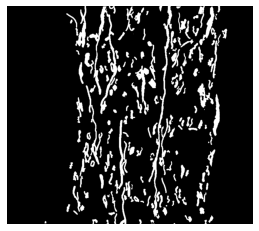

In [ ]:
label_slice = labels[0].dataobj[...,400]
plt.imshow(label_slice, cmap='gray')
plt.axis('off')
plt.show()

Saving preprocessed labels

In [6]:
data_folder_list = glob.glob(os.path.join(data_path, "*\\"), recursive=True)

In [7]:
data_prep_folder_list = [folder.replace('cropped_data', 'prep_data') for folder in data_folder_list]

In [8]:
for folder, label in zip(data_prep_folder_list, labels):
    if not os.path.exists(folder):
        os.makedirs(folder)
    nib.save(label, f"{folder}y_prep.nii.gz")

Normalizing images

In [14]:
images[0].get_fdata().max()

255.0

- Images have pixel values from 0 to 255, it will be better for a model to have them from 0 to 1

In [15]:
for idx, image in enumerate(images):
    header = image.header
    header.extensions.clear()
    affine = image.affine
    dataobj = np.array(image.dataobj, dtype=np.float32)/255
    images[idx] = nib.Nifti1Image(dataobj, affine, header)

In [16]:
images[0].get_fdata().max()

1.0

Saving preprocessed images

In [17]:
for folder, image in zip(data_prep_folder_list, images):
    nib.save(image, f"{folder}x_prep.nii.gz")

Closer look at data sizes

Original data:

In [18]:
print(f"Image file size: \
        {os.path.getsize(f'{data_folder_list[0]}x.nii.gz')/1000000} MB")
print(f"Label file size: \
        {os.path.getsize(f'{data_folder_list[0]}y.nii.gz')/1000000} MB")

Image file size:         348.585089 MB
Label file size:         13.030873 MB


Preprocessed data:

In [19]:
print(f"Image file size: \
        {os.path.getsize(f'{data_prep_folder_list[0]}x_prep.nii.gz')/1000000} MB")
print(f"Label file size: \
        {os.path.getsize(f'{data_prep_folder_list[0]}y_prep.nii.gz')/1000000} MB")

Image file size:         348.585101 MB
Label file size:         20.690446 MB
